# Centro de Informática - UFPE
## Introdução à Aprendizagem Profunda

**Aluno**: Victor Gabriel de Carvalho (vgc3)

**Professor**: Tsang Ing Ren / George Darmiton da Cunha Cavalcanti

**LISTA PRÁTICA DAS UNIDADES 1 E 2**

Pode ser feita com o grupo do projeto. Recomendo pair/group programming para que todos vejam um pouco de todas as partes.


Treine e avalie 4 modelos de classificação para a base de dados do FashionMNIST (https://www.kaggle.com/datasets/zalando-research/fashionmnist,
https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).



1.   Um modelo base que não seja uma rede neural, como _decision tree, xgboost, random forest_, etc. Recomendação: use o sklearn (https://scikit-learn.org/).

2.   Uma MLP

3. Uma rede convolucional criada por ti. Recomendação: https://pytorch.org/

4. Use um modelo pré treinado já consolidado na literatura para fazer _transfer learning_. Recomendações: https://pytorch.org/hub/pytorch_vision_vgg/


Compare os resultados dos modelos:
* plote gráficos que mostrem as acurácias de cada modelo
* Indique qual foi a classe na qual o modelo teve pior performance (indique qual métrica usou para concluir isso e faça para cada modelo)
* argumente qual o melhor modelo levando em consideração o tempo de execução e acurácia.

Recomendação use:
https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html .



Recomendação:

Faça um template de treino, validação e teste que funcione para uma API de modelo.

Crie a API para cada modelo que será usado e use o template

---
# Imports e Downloads

In [ ]:
import time
import psutil
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import v2
from torchvision.models import vgg16, VGG16_Weights, resnet34, ResNet34_Weights, mobilenet_v3_small, MobileNet_V3_Small_Weights

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Definiremos uma random seed para garantir reprodutibilidade. Nos métodos do `sklearn`(usados pelo modelo base), a random seed é passada como parâmetro.

In [ ]:
torch.manual_seed(9)
torch.cuda.manual_seed(9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Dataset
O trecho de código abaixo faz o download do dataset Fashion MNIST, que já está incluso no `torchvision.datasets`, eliminando a necessidade de downloads adicionais. O dataset é composto por 60000 imagens de treinamento e 10000 imagens de teste. As imagens tem a resolução de (28 x 28) e são em escala de cinza (1 x 28 x 28).

> Usaremos a classe customizada `MyDataset` para podermos aplicar diferentes transformações ao longo das implementações.

In [ ]:
train_dataset = FashionMNIST(root='./data', train=True, download=True)
test_dataset = FashionMNIST(root='./data', train=False, download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 14949730.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267680.82it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4863281.18it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 2254361.77it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

### Dataset para o Modelo Base
A versão do dataset usada no modelo base consistirá apenas do conjunto de treinamento e teste e não será necessário um dataloader. Iremos apenas dividir o `train_dataset` e `test_dataset` entre as features (imagem) `X_` e as labels (classes) `y_`.

In [ ]:
base_transforms = v2.Compose([
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
])

train_base_dataset = MyDataset(train_dataset, base_transforms)
test_base_dataset = MyDataset(test_dataset, base_transforms)

X_train = np.array([np.array(sample[0]) for sample in train_base_dataset])
y_train = np.array([np.array(sample[1]) for sample in train_base_dataset])

X_test = np.array([np.array(sample[0]) for sample in test_base_dataset])
y_test = np.array([np.array(sample[1]) for sample in test_base_dataset])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 1, 28, 28), (60000,), (10000, 1, 28, 28), (10000,))

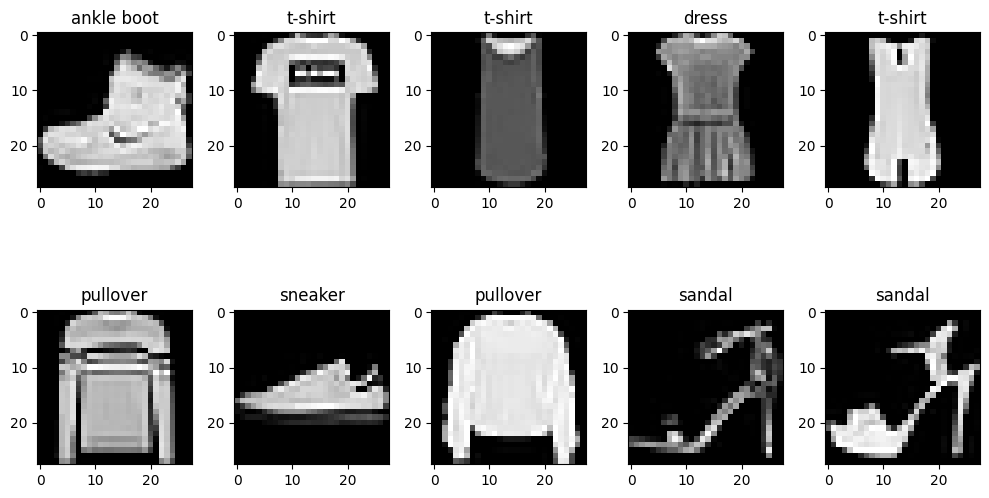

In [ ]:
labels_title = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for idx in range(10):
    ax[idx//5][idx%5].imshow(X_train[idx].reshape(28, 28), cmap='gray')
    ax[idx//5][idx%5].set_title(labels_title[y_train[idx]])
plt.tight_layout()
plt.show()

### Dataset para MLP e CNN
Nesse caso, devido à maior flexibilidade do PyTorch, podemos dividir os dados em treinamento, validação e teste, além de possibilitar o uso de dataloaders para carregarmos bathces de dados (possiblitando, também, a data). O trecho de código abaixo faz a divisão dos datasets, onde 20% dos dados de treinamento irão para a validação.

In [ ]:
mlp_cnn_transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
])

train_mlp_cnn_dataset = MyDataset(train_dataset, mlp_cnn_transforms)
test_mlp_cnn_dataset = MyDataset(test_dataset, base_transforms)

In [ ]:
num_samples = len(train_dataset)
indices = list(range(num_samples))

split_ratio = 0.8
split_idx = int(num_samples * split_ratio)

train_indices, val_indices = indices[:split_idx], indices[split_idx:]
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

BATCH_SIZE = 128
train_mlp_cnn_loader = DataLoader(train_mlp_cnn_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_mlp_cnn_loader = DataLoader(train_mlp_cnn_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_mlp_cnn_loader = DataLoader(test_mlp_cnn_dataset, batch_size=BATCH_SIZE, shuffle=True)

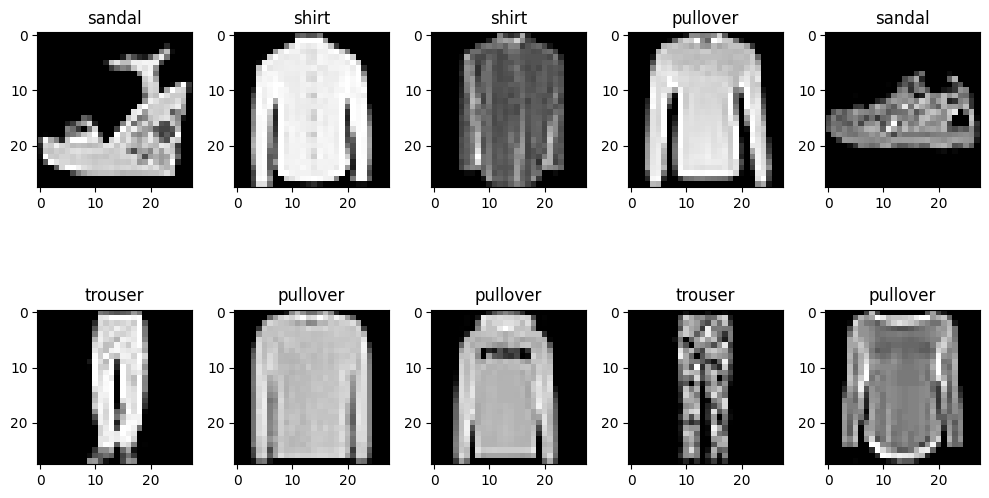

In [ ]:
it = iter(train_mlp_cnn_loader)
images, labels = next(it)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for idx in range(10):
    ax[idx//5][idx%5].imshow(images[idx].permute(1, 2, 0), cmap='gray')
    ax[idx//5][idx%5].set_title(labels_title[labels[idx]])
plt.tight_layout()
plt.show()

### Dataset para CNNs consolidadas
A maioria das CNNs consolidadadas foi projetada para trabalhar com o dataset ImageNet, que contem imagens (3 x 224 x 224). Dessa forma, as imagens bem menores do FashionMNIST não conseguiriam ser processadas por essas redes (seu tamanho desapareceria após uma certa quantidade de camadas pooling).

Pare resolver esse problema e mantermos fiel às arquiteturas originais das CNNs, iremos apenas das um `v2.Resize` nas imagens do dataset (mesmo sabendo que tal operação não adicionaria informação nenhuma, apenas gastaria mais recursos). Podemos perceber o reajuste através dos eixos do `plt.imshow`.

In [ ]:
cnn_cons_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
])

cnn_cons_data_transforms = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.ToImage(), v2.ToDtype(torch.float32, scale=True)
])

train_cnn_cons_dataset = MyDataset(train_dataset, cnn_cons_transforms)
test_cnn_cons_dataset = MyDataset(test_dataset, cnn_cons_data_transforms)

In [ ]:
BATCH_SIZE = 64
train_cnn_cons_loader = DataLoader(train_cnn_cons_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_cnn_cons_loader = DataLoader(train_cnn_cons_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)
test_cnn_cons_loader = DataLoader(test_cnn_cons_dataset, batch_size=BATCH_SIZE, shuffle=True)

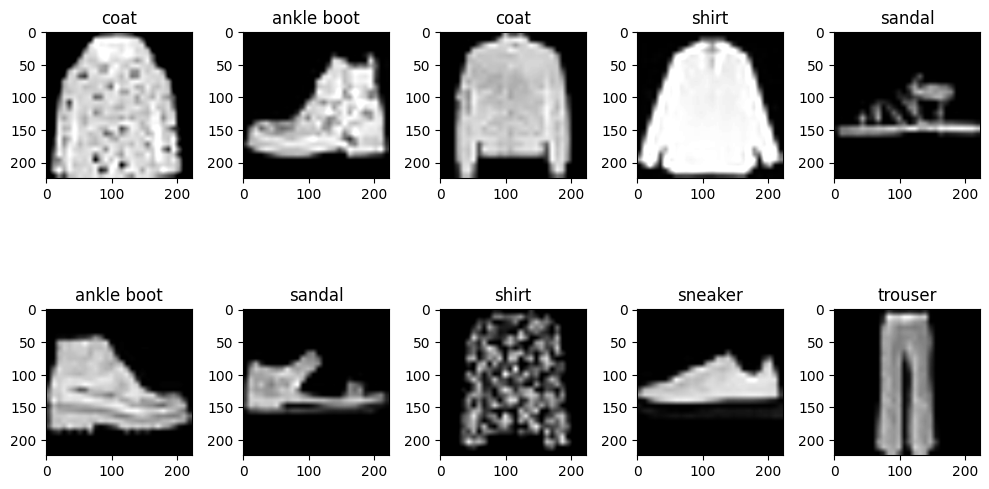

In [ ]:
it = iter(train_cnn_cons_loader)
images, labels = next(it)

fig, ax = plt.subplots(2, 5, figsize=(10, 6))
for idx in range(10):
    ax[idx//5][idx%5].imshow(images[idx].permute(1, 2, 0), cmap='gray')
    ax[idx//5][idx%5].set_title(labels_title[labels[idx]])
plt.tight_layout()
plt.show()

### Funções Auxiliares

In [ ]:
def train(model, train_loader, val_loader, max_epochs, loss_fn, optimizer, patience=5):
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []

    best_val_loss = float('inf')
    counter = 0

    ram_usage = 0
    vram_allocated = 0
    time_0 = time.time()
    for epoch in range(1, max_epochs+1):
        train_loss = 0.0
        for (images, labels) in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            model.train()
            y_pred = model(images)

            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ram_usage = psutil.virtual_memory().used / (1024 ** 3)
            vram_allocated = torch.cuda.max_memory_allocated(device) / (1024 ** 3)

        val_acc = 0.0
        val_loss = 0.0
        model.eval()
        with torch.inference_mode():
            for (images, labels) in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)

                y_val_pred = model(images)
                val_loss += loss_fn(y_val_pred, labels).item()
                val_acc += accuracy_score(labels.cpu(), torch.argmax(y_val_pred, dim=1).cpu())

            val_loss /= len(val_loader)
            val_loss_list.append(val_loss)
            val_acc /= len(val_loader)
            val_acc_list.append(val_acc)

        train_loss /= len(train_loader)
        train_loss_list.append(train_loss)
        print(f"{epoch:02d}: Train loss: {train_loss:.5f}, RAM Usage: {ram_usage:.2}GB, VRAM Usage: {vram_allocated:.2}GB | Validation loss: {val_loss:.5f}, Validation acc: {(val_acc * 100):.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    time_f = time.time()

    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(train_loss_list, label='Train loss')
    ax.plot(val_loss_list, label='Validation loss:')
    ax.set_title("Loss value during training")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (CrossEntropy)')
    ax.legend()

    torch.cuda.reset_peak_memory_stats(device)
    return (time_f - time_0), ram_usage, vram_allocated


def test(model, test_loader, loss_fn):
    test_loss = 0.0
    y_pred = []
    y_true = []

    time_0 = time.time()
    model.eval()
    with torch.inference_mode():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            y_test_pred_logits = model(images)
            test_loss += loss_fn(y_test_pred_logits, labels).item()

            y_test_pred = model.predict(images)
            y_pred.extend(y_test_pred.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)

    time_f = time.time()
    return y_pred, y_true, test_loss, (time_f - time_0)

Nesse dicionário serão guardadas as informações de cada modelo. Esses dados serão usados em uma posterior análise.
> Tr Time: Tempo de treinamento no dataset de treino.

> Pr Time: Pempo de previsão no dataset de teste.

> Accuracy: Acurácia no no dataset de teste.

> RAM: Uso de RAM pelo sistema na ultima época.

> VRAM: Uso máximo de VRAM da GPU.

In [ ]:
models = {'Decision Tree': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'Random Forest': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'SVM': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'MLP': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'Custom CNN': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'VGG16': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'ResNet34': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0},
          'MobileNetV3': {'Tr Time': 0, 'Pr Time': 0, 'Accuracy': 0, 'RAM': 0, 'VRAM': 0}}

---
# Modelo base
O modelo base será algum método que não seja um rede neural, para que possamos comparar ele com as técnicas mais robustas de MLP e CNN. Como base, usaremos algumas técnicas como Decision Tree, Random Forest e XGBoost.

> Note que nenhum desses modelos, originalmente, foram feitos para trabalhar com imagens. Para resolver esse problema, usaremos o método `ndarray.reshape`, para que as imagens (28 x 28) se tornem vetores (784). Os dados também serão escalonados para valores entre 0 e 1.

### Decision Tree
Árvores de decisão representam um modelo de tomada de decisão que é estruturado como uma árvore, na qual cada nó interno representa uma decisão com base em um atributo específico, cada ramo representa o resultado dessa decisão e cada folha representa a classe ou valor de saída.

In [ ]:
class MyDecisionTree():
    def __init__(self, random_state=None):
        self.dtc = DecisionTreeClassifier(random_state=random_state)

    def flatten_scale(self, images):
        return images.reshape((images.shape[0], -1)) / 255

    def fit(self, images, labels):
        images_flat_scale = self.flatten_scale(images)
        self.dtc.fit(images_flat_scale, labels)

    def predict(self, images):
        images_flat_scale = self.flatten_scale(images)
        return self.dtc.predict(images_flat_scale)

In [ ]:
decision_tree = MyDecisionTree(random_state=9)

time_0 = time.time()
decision_tree.fit(X_train, y_train)
time_f = time.time()
trtime_dt = (time_f-time_0)

time_0 = time.time()
y_test_pred_dt = decision_tree.predict(X_test)
time_f = time.time()
prtime_dt = (time_f-time_0)

print(classification_report(y_test, y_test_pred_dt))
print(f'Time spent: {trtime_dt:.2f}s')
models['Decision Tree']['Accuracy'] = accuracy_score(y_test, y_test_pred_dt)
models['Decision Tree']['Tr Time'] = trtime_dt
models['Decision Tree']['Pr Time'] = prtime_dt

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1000
           1       0.95      0.95      0.95      1000
           2       0.63      0.64      0.64      1000
           3       0.82      0.78      0.80      1000
           4       0.65      0.65      0.65      1000
           5       0.92      0.89      0.90      1000
           6       0.53      0.55      0.54      1000
           7       0.87      0.89      0.88      1000
           8       0.91      0.91      0.91      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000

Time spent: 39.36s


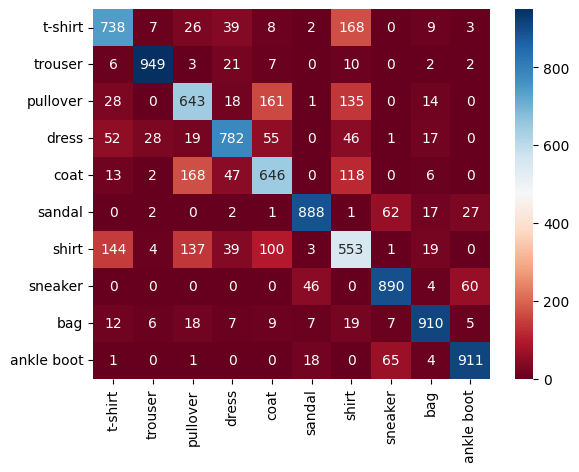

In [ ]:
cmatrix = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

### Random Forest
Random Forest é uma extensão das árvores de decisão que visa melhorar a robustez e a precisão do modelo por meio do conceito de ensemble learning, que combina vários modelos individuais para formar um modelo mais poderoso e geral. O processo de construção de uma Random Forest envolve a geração de várias árvores de decisão, cada uma treinada em uma amostra aleatória e independente dos dados originais.

In [ ]:
class MyRandomForest():
    def __init__(self, random_state=None):
        self.rfc = RandomForestClassifier(random_state=random_state)

    def flatten_scale(self, images):
        return images.reshape((images.shape[0], -1)) / 255

    def fit(self, images, labels):
        images_flat_scale = self.flatten_scale(images)
        self.rfc.fit(images_flat_scale, labels)

    def predict(self, images):
        images_flat_scale = self.flatten_scale(images)
        return self.rfc.predict(images_flat_scale)

In [ ]:
random_forest = MyRandomForest(random_state=9)

time_0 = time.time()
random_forest.fit(X_train, y_train)
time_f = time.time()
trtime_rf = (time_f-time_0)

time_0 = time.time()
y_test_pred_rf = random_forest.predict(X_test)
time_f = time.time()
prtime_rf = (time_f-time_0)

print(classification_report(y_test, y_test_pred_rf))
print(f'Time spent: {trtime_rf:.2f}s')
models['Random Forest']['Accuracy'] = accuracy_score(y_test, y_test_pred_rf)
models['Random Forest']['Tr Time'] = trtime_rf
models['Random Forest']['Pr Time'] = prtime_rf

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.76      0.81      0.79      1000
           3       0.87      0.91      0.89      1000
           4       0.77      0.82      0.79      1000
           5       0.98      0.96      0.97      1000
           6       0.72      0.58      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.87     10000
weighted avg       0.88      0.88      0.87     10000

Time spent: 94.37s


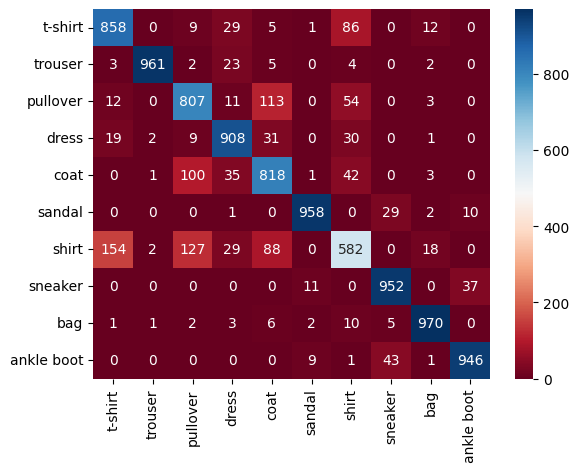

In [ ]:
cmatrix = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

### SVM


In [ ]:
class MySVM():
    def __init__(self, random_state=None):
        self.svm = SVC(random_state=random_state)

    def flatten_scale(self, images):
        return images.reshape((images.shape[0], -1)) / 255

    def fit(self, images, labels):
        images_flat_scale = self.flatten_scale(images)
        self.svm.fit(images_flat_scale, labels)

    def predict(self, images):
        images_flat_scale = self.flatten_scale(images)
        return self.svm.predict(images_flat_scale)

In [ ]:
svm = MySVM(random_state=9)

time_0 = time.time()
svm.fit(X_train, y_train)
time_f = time.time()
trtime_svm = (time_f-time_0)

time_0 = time.time()
y_test_pred_svm = svm.predict(X_test)
time_f = time.time()
prtime_svm = (time_f-time_0)

print(classification_report(y_test, y_test_pred_svm))
print(f'Time spent: {trtime_svm:.2f}s')
models['SVM']['Accuracy'] = accuracy_score(y_test, y_test_pred_svm)
models['SVM']['Tr Time'] = trtime_svm
models['SVM']['Pr Time'] = prtime_svm

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.79      0.82      0.80      1000
           3       0.87      0.89      0.88      1000
           4       0.81      0.81      0.81      1000
           5       0.96      0.95      0.96      1000
           6       0.72      0.65      0.69      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.98      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Time spent: 310.99s


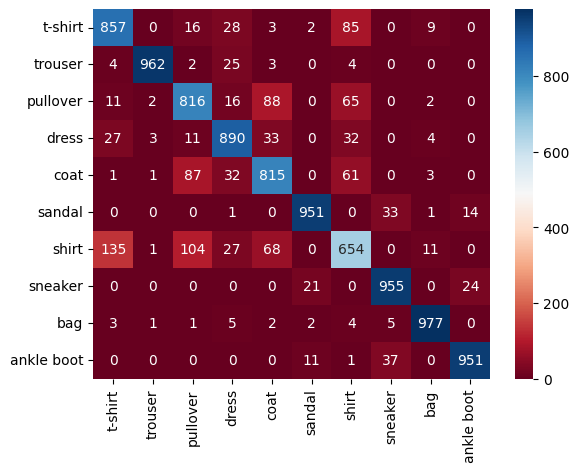

In [ ]:
cmatrix = confusion_matrix(y_test, y_test_pred_svm)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

---
# MLP
A MLP (Multilayer Perceptron) pertence à categoria de modelos de aprendizado profundo. Consiste numa rede neural artificial onde os perceptrons são organizados em camadas. Assim como nos modelos base, MLPs também não lidam com entradas multidimensionais  (como imagens), utilizaremos o método `nn.Flatten` do PyTorch para redimensionar a entrada para um vetor.

> A rede será treinada por 15 épocas.

In [ ]:
class MyMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyMLP, self).__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(nn.Linear(input_size, 256), nn.ReLU(),
                                 nn.Linear(256, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=0.5),
                                 nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=0.25),
                                 nn.Linear(32, output_size))

    def forward(self, x):
        return self.net(self.flatten(x))

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
input_size = 28*28
output_size = 10

model_mlp = MyMLP(input_size, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.001)

model_mlp

MyMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.25, inplace=False)
    (10): Linear(in_features=32, out_features=10, bias=True)
  )
)

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

01: Train loss: 1.14873, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.70286, Validation acc: 74.59%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

02: Train loss: 0.70898, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.50661, Validation acc: 82.26%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

03: Train loss: 0.58356, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.48684, Validation acc: 82.84%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

04: Train loss: 0.52152, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.44511, Validation acc: 84.32%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

05: Train loss: 0.49080, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.41903, Validation acc: 85.27%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

06: Train loss: 0.46917, RAM Usage: 2.3GB, VRAM Usage: 0.021GB | Validation loss: 0.40675, Validation acc: 86.08%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

07: Train loss: 0.44795, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.38587, Validation acc: 86.46%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

08: Train loss: 0.42813, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.39498, Validation acc: 85.84%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

09: Train loss: 0.41300, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.37344, Validation acc: 86.63%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

10: Train loss: 0.40456, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.37420, Validation acc: 87.29%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

11: Train loss: 0.38572, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.37845, Validation acc: 86.69%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

12: Train loss: 0.37907, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.36921, Validation acc: 87.04%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

13: Train loss: 0.37354, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.35637, Validation acc: 87.22%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

14: Train loss: 0.36358, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.35773, Validation acc: 87.76%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

15: Train loss: 0.35728, RAM Usage: 2.4GB, VRAM Usage: 0.021GB | Validation loss: 0.36777, Validation acc: 87.31%


  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.74      0.83      0.78      1000
           3       0.87      0.88      0.88      1000
           4       0.77      0.79      0.78      1000
           5       0.94      0.96      0.95      1000
           6       0.71      0.62      0.66      1000
           7       0.95      0.87      0.91      1000
           8       0.97      0.97      0.97      1000
           9       0.89      0.96      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000

Test loss: 0.3870
Time spent: 590.05s


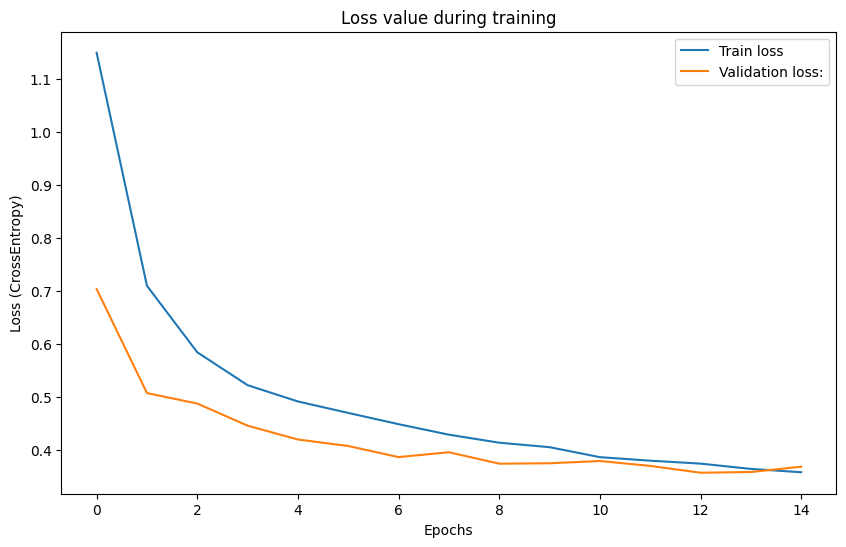

In [ ]:
trtime_mlp, ram_mlp, vram_mlp = train(model_mlp, train_mlp_cnn_loader, val_mlp_cnn_loader, 15, loss_fn, optimizer)

y_test_pred_mlp, y_true, test_loss, prtime_mlp = test(model_mlp, test_mlp_cnn_loader, loss_fn)
print(classification_report(y_true, y_test_pred_mlp))
print(f'Test loss: {test_loss:.4f}')
print(f'Time spent: {trtime_mlp:.2f}s')
models['MLP']['Accuracy'] = (accuracy_score(y_true, y_test_pred_mlp))
models['MLP']['Tr Time'] = trtime_mlp
models['MLP']['Pr Time'] = prtime_mlp
models['MLP']['RAM'] = ram_mlp
models['MLP']['VRAM'] = vram_mlp

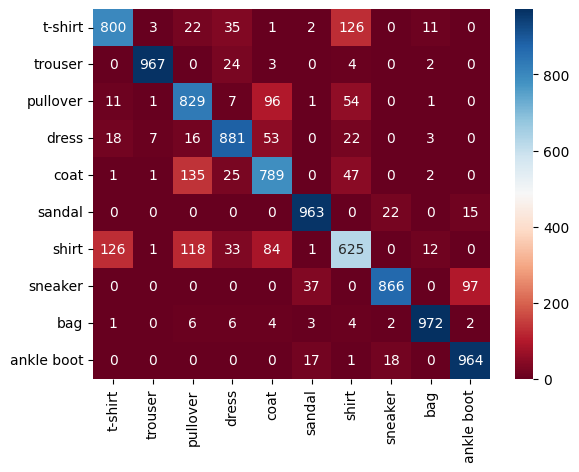

In [ ]:
cmatrix = confusion_matrix(y_true, y_test_pred_mlp)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

---
# Rede Convolucional
Finalmente usaremos a primeira arquitetura proposta para, de fato, trabalhar com dados estruturados em forma de grade, especialmente em tarefas relacionadas a imagens. As CNNs conseguem estrair relações de localidade nos dados e ainda usam menos parâmetros que uma ANN do mesmo porte, alem de podermos utilizar os recursos de GPU disponíveis.

> A rede convolucional será treinada por 15 épocas.

In [ ]:
class MyCNN(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super(MyCNN, self).__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels=in_channels,  # 1x28x28
                                             out_channels=4,
                                             kernel_size=3,
                                             padding=1),
                                   nn.BatchNorm2d(num_features=4),
                                   nn.ReLU(inplace=True),  # 4x28x28
                                   nn.MaxPool2d(kernel_size=2, stride=2),

                                   nn.Conv2d(in_channels=4,  # 4x14x14
                                             out_channels=8,
                                             kernel_size=3,
                                             padding=1),
                                   nn.BatchNorm2d(num_features=8),
                                   nn.ReLU(inplace=True),  # 8x14x14
                                   nn.MaxPool2d(kernel_size=2, stride=2))  # 8x7x7
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(nn.Linear(8*7*7, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU(), nn.Dropout(p=0.5),
                                 nn.Linear(64, 32), nn.ReLU(), nn.Dropout(p=0.25),
                                 nn.Linear(32, output_size))

    def forward(self, x):
        return self.net(self.flatten(self.convs(x)))

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
output_size = 10

model_cnn = MyCNN(1, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

model_cnn

MyCNN(
  (convs): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=392, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=32, out_feature

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

01: Train loss: 0.98486, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.52172, Validation acc: 80.50%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

02: Train loss: 0.57361, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.43979, Validation acc: 84.39%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

03: Train loss: 0.49295, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.38360, Validation acc: 85.88%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

04: Train loss: 0.45786, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.37053, Validation acc: 86.44%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

05: Train loss: 0.42525, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.35827, Validation acc: 87.16%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

06: Train loss: 0.40760, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.34539, Validation acc: 87.43%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

07: Train loss: 0.38887, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.32637, Validation acc: 88.19%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

08: Train loss: 0.37108, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.32565, Validation acc: 88.08%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

09: Train loss: 0.36487, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.33433, Validation acc: 87.75%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

10: Train loss: 0.35530, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.33569, Validation acc: 87.68%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

11: Train loss: 0.34528, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.32688, Validation acc: 88.44%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

12: Train loss: 0.33226, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.33455, Validation acc: 88.07%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

13: Train loss: 0.32504, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.31472, Validation acc: 88.93%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

14: Train loss: 0.31755, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.30506, Validation acc: 89.37%


  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]

15: Train loss: 0.31511, RAM Usage: 2.5GB, VRAM Usage: 0.028GB | Validation loss: 0.30149, Validation acc: 89.34%


  0%|          | 0/79 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.85      0.92      0.89      1000
           4       0.79      0.84      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.76      0.64      0.69      1000
           7       0.92      0.96      0.94      1000
           8       0.98      0.96      0.97      1000
           9       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Test loss: 0.3217
Time spent: 625.57s


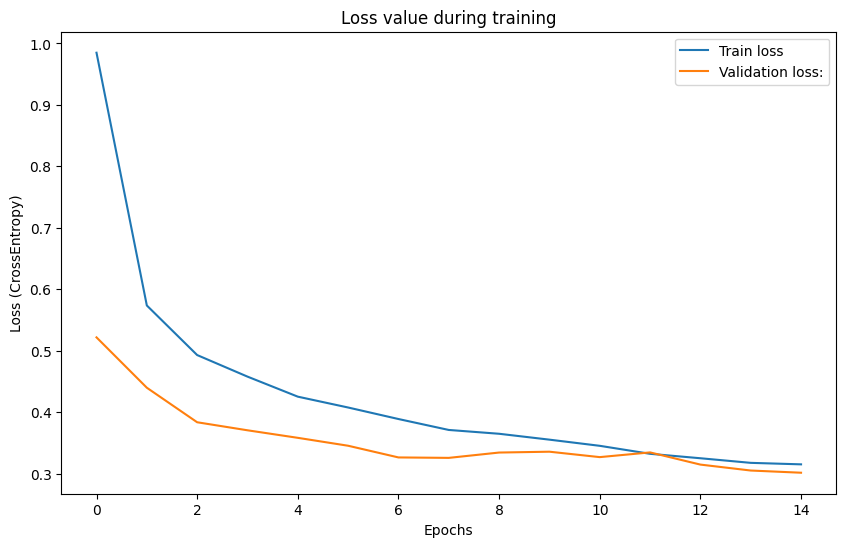

In [ ]:
trtime_cnn, ram_cnn, vram_cnn = train(model_cnn, train_mlp_cnn_loader, val_mlp_cnn_loader, 15, loss_fn, optimizer)

y_test_pred_cnn, y_true, test_loss, prtime_cnn = test(model_cnn, test_mlp_cnn_loader, loss_fn)
print(classification_report(y_true, y_test_pred_cnn))
print(f'Test loss: {test_loss:.4f}')
print(f'Time spent: {trtime_cnn:.2f}s')
models['Custom CNN']['Accuracy'] = (accuracy_score(y_true, y_test_pred_cnn))
models['Custom CNN']['Tr Time'] = trtime_cnn
models['Custom CNN']['Pr Time'] = prtime_cnn
models['Custom CNN']['RAM'] = ram_cnn
models['Custom CNN']['VRAM'] = vram_cnn

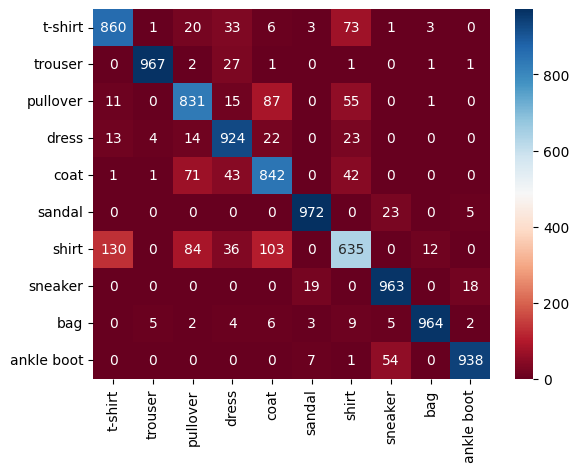

In [ ]:
cmatrix = confusion_matrix(y_true, y_test_pred_cnn)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

---
# Rede Convolucional consolidada
Para essa seção, usaremos as redes VGG-16, ResNet-34 e MobileNetV3 famosas por seus desempenhos na competição ImageNet e usadas até hoje como opções de transfer learning. Para tal, precisaremos mudar a primeira e ultima camada de cada modelo, já que temos 10 classes e 1 canal de entrada (o que não ocorre nos modelos originais).

> Todas as redes consolidadas serão treinadas por 5 épocas.

### VGG-16
A VGG-16 é uma arquitetura de rede neural convolucional desenvolvida pela Visual Geometry Group (VGG). A VGG-16 é conhecida por sua simplicidade relativa, apresentando convoluções 3x3 consecutivas em várias camadas, seguidas por camadas de pooling.

> Cada agrupamento de convoluções seguidas por pooling configura um bloco VGG. A quantidade de blocos define qual rede da família será usada.

In [ ]:
class MyVGG16(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super(MyVGG16, self).__init__()
        self.vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=10, bias=True)

    def forward(self, x):
        return self.vgg(x)

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
output_size = 10

model_vgg = MyVGG16(1, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg.parameters(), lr=0.0001)

model_vgg

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 70.1MB/s]


MyVGG16(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

01: Train loss: 0.43226, RAM Usage: 2.6GB, VRAM Usage: 7.8GB | Validation loss: 0.24820, Validation acc: 90.92%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

02: Train loss: 0.24344, RAM Usage: 2.6GB, VRAM Usage: 7.8GB | Validation loss: 0.21469, Validation acc: 92.10%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

03: Train loss: 0.20038, RAM Usage: 2.6GB, VRAM Usage: 7.8GB | Validation loss: 0.20606, Validation acc: 92.46%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

04: Train loss: 0.17367, RAM Usage: 2.6GB, VRAM Usage: 7.8GB | Validation loss: 0.19358, Validation acc: 92.95%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

05: Train loss: 0.15461, RAM Usage: 2.6GB, VRAM Usage: 7.8GB | Validation loss: 0.19140, Validation acc: 93.13%


  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.89      0.88      0.89      1000
           3       0.92      0.95      0.93      1000
           4       0.93      0.85      0.89      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.78      0.79      1000
           7       0.94      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.94      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Test loss: 0.2019
Time spent: 3668.58s


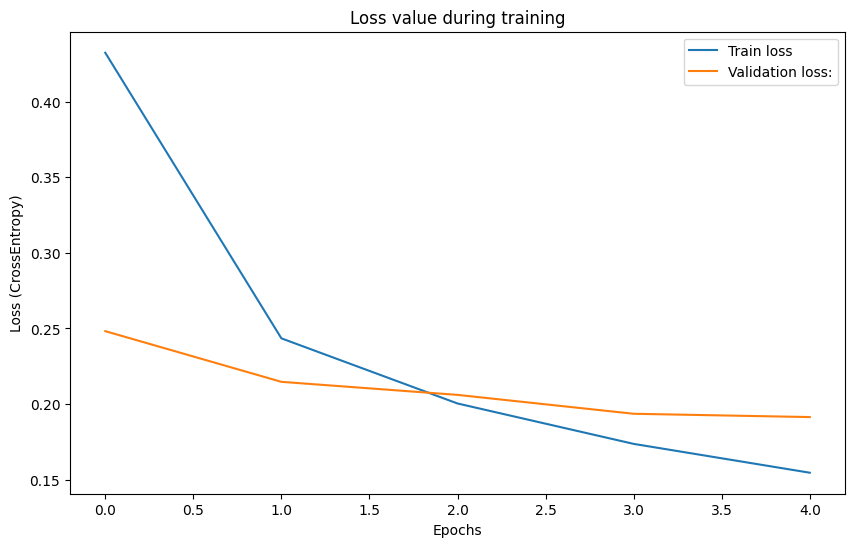

In [ ]:
trtime_vgg, ram_vgg, vram_vgg = train(model_vgg, train_cnn_cons_loader, val_cnn_cons_loader, 5, loss_fn, optimizer)

y_test_pred_vgg, y_true, test_loss, prtime_vgg = test(model_vgg, test_cnn_cons_loader, loss_fn)
print(classification_report(y_true, y_test_pred_vgg))
print(f'Test loss: {test_loss:.4f}')
print(f'Time spent: {trtime_vgg:.2f}s')
models['VGG16']['Accuracy'] = (accuracy_score(y_true, y_test_pred_vgg))
models['VGG16']['Tr Time'] = trtime_vgg
models['VGG16']['Pr Time'] = prtime_vgg
models['VGG16']['RAM'] = ram_vgg
models['VGG16']['VRAM'] = vram_vgg

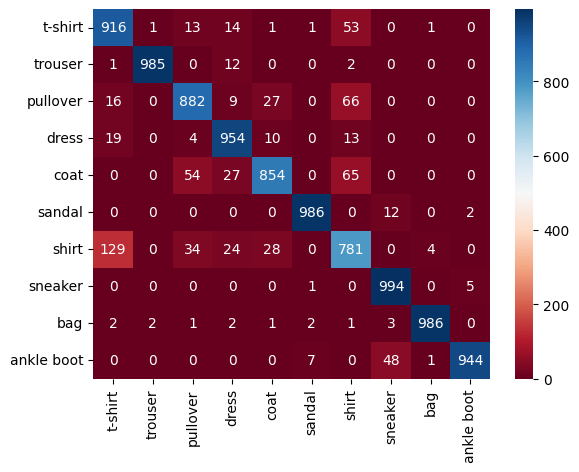

In [ ]:
cmatrix = confusion_matrix(y_true, y_test_pred_vgg)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

### ResNet-34
A ResNet-34 é uma variação da arquitetura ResNet (Residual Network). A principal inovação das redes ResNet é a introdução de blocos residuais, que ajudam a superar o problema de degradação do desempenho observado em redes mais profundas.

> O conceito central da ResNet é o uso de blocos residuais, que introduzem conexões de atalho (skip connections) para pular uma ou mais camadas. Essas conexões permitem que o gradiente flua diretamente através do bloco, facilitando o treinamento de redes muito profundas.

In [ ]:
class MyResNet34(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super(MyResNet34, self).__init__()
        self.rn34 = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.rn34.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.rn34.fc = nn.Linear(in_features=512, out_features=10, bias=True)

    def forward(self, x):
        return self.rn34(x)

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
output_size = 10

model_rn34 = MyResNet34(1, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rn34.parameters(), lr=0.0001)

model_rn34

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 143MB/s]


MyResNet34(
  (rn34): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

01: Train loss: 0.31723, RAM Usage: 2.7GB, VRAM Usage: 7.0GB | Validation loss: 0.25878, Validation acc: 90.57%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

02: Train loss: 0.20265, RAM Usage: 2.7GB, VRAM Usage: 7.0GB | Validation loss: 0.19366, Validation acc: 93.06%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

03: Train loss: 0.16588, RAM Usage: 2.7GB, VRAM Usage: 7.0GB | Validation loss: 0.17980, Validation acc: 93.33%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

04: Train loss: 0.14511, RAM Usage: 2.7GB, VRAM Usage: 7.0GB | Validation loss: 0.17648, Validation acc: 93.60%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

05: Train loss: 0.12883, RAM Usage: 2.7GB, VRAM Usage: 7.0GB | Validation loss: 0.17260, Validation acc: 93.95%


  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.90      0.91      0.90      1000
           3       0.96      0.92      0.94      1000
           4       0.88      0.93      0.91      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.83      0.81      1000
           7       0.94      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.94      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.94     10000
weighted avg       0.94      0.93      0.94     10000

Test loss: 0.1770
Time spent: 1281.24s


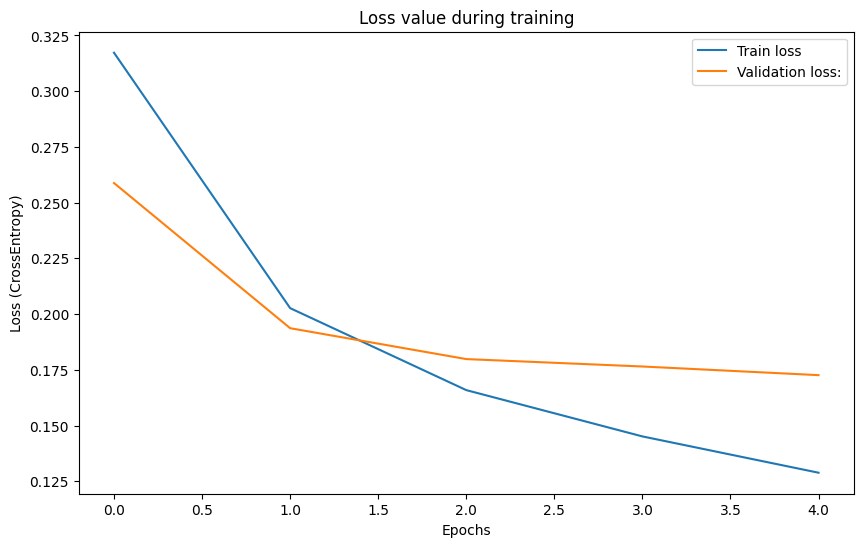

In [ ]:
trtime_rn34, ram_rn34, vram_rn34 = train(model_rn34, train_cnn_cons_loader, val_cnn_cons_loader, 5, loss_fn, optimizer)

y_test_pred_rn34, y_true, test_loss, prtime_rn34 = test(model_rn34, test_cnn_cons_loader, loss_fn)
print(classification_report(y_true, y_test_pred_rn34))
print(f'Test loss: {test_loss:.4f}')
print(f'Time spent: {trtime_rn34:.2f}s')
models['ResNet34']['Accuracy'] = (accuracy_score(y_true, y_test_pred_rn34))
models['ResNet34']['Tr Time'] = trtime_rn34
models['ResNet34']['Pr Time'] = prtime_rn34
models['ResNet34']['RAM'] = ram_rn34
models['ResNet34']['VRAM'] = vram_rn34

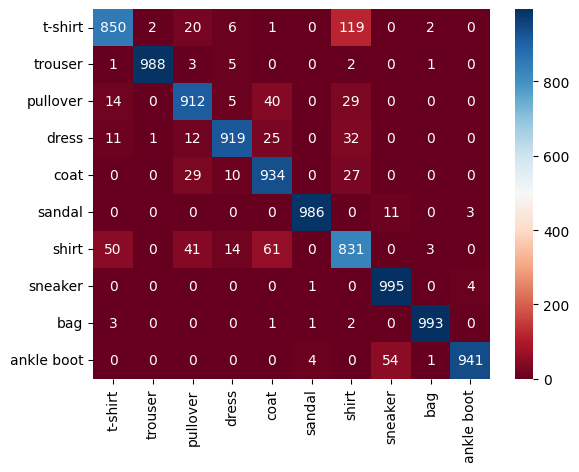

In [ ]:
cmatrix = confusion_matrix(y_true, y_test_pred_rn34)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

### MobileNetV3
A MobileNetV3 é uma arquitetura de rede neural projetada para tarefas de visão computacional, especialmente otimizada para ambientes com recursos computacionais limitados, como dispositivos móveis.

> A arquitetura MobileNetV3 introduz o bloco invertido residual (MBConv), que é uma versão modificada do bloco residual usado em redes como a ResNet. Esse bloco ajuda a manter a eficiência computacional

In [ ]:
class MyMobileNetV3(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super(MyMobileNetV3, self).__init__()
        self.mn3 = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.mn3.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.mn3.fc = nn.Linear(in_features=512, out_features=10, bias=True)

    def forward(self, x):
        return self.mn3(x)

    def predict(self, x):
        return torch.argmax(self.forward(x), dim=1)

In [ ]:
output_size = 10

model_mn3 = MyMobileNetV3(1, output_size).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mn3.parameters(), lr=0.0001)

model_mn3

MyMobileNetV3(
  (mn3): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

01: Train loss: 0.30794, RAM Usage: 2.7GB, VRAM Usage: 3.5GB | Validation loss: 0.21168, Validation acc: 92.13%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

02: Train loss: 0.19648, RAM Usage: 2.7GB, VRAM Usage: 3.5GB | Validation loss: 0.18851, Validation acc: 93.07%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

03: Train loss: 0.16587, RAM Usage: 2.8GB, VRAM Usage: 3.5GB | Validation loss: 0.17318, Validation acc: 93.65%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

04: Train loss: 0.14199, RAM Usage: 2.7GB, VRAM Usage: 3.5GB | Validation loss: 0.17032, Validation acc: 93.78%


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/188 [00:00<?, ?it/s]

05: Train loss: 0.12702, RAM Usage: 2.1GB, VRAM Usage: 3.5GB | Validation loss: 0.17921, Validation acc: 93.50%


  0%|          | 0/157 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1000
           1       1.00      0.98      0.99      1000
           2       0.90      0.94      0.92      1000
           3       0.91      0.95      0.93      1000
           4       0.94      0.87      0.91      1000
           5       1.00      0.97      0.98      1000
           6       0.80      0.86      0.83      1000
           7       0.94      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.95      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Test loss: 0.1756
Time spent: 1276.82s


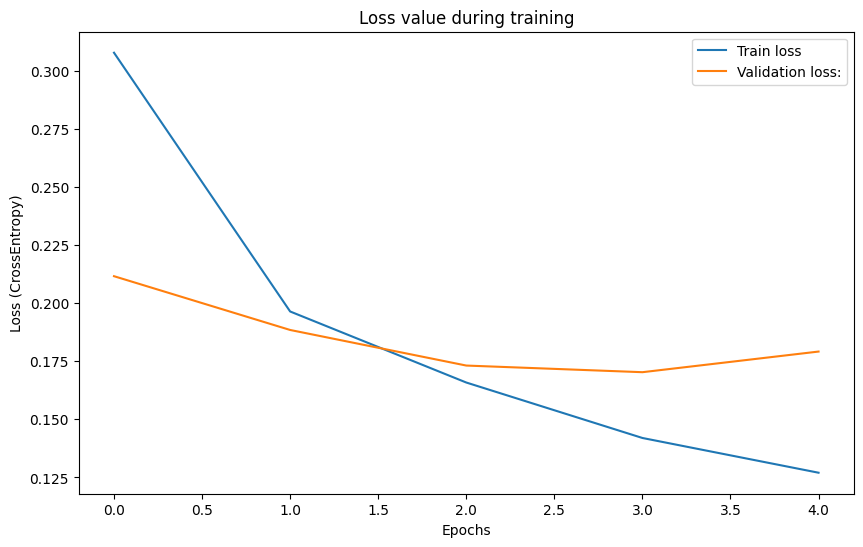

In [ ]:
trtime_mn3, ram_mn3, vram_mn3 = train(model_mn3, train_cnn_cons_loader, val_cnn_cons_loader, 5, loss_fn, optimizer)

y_test_pred_mn3, y_true, test_loss, prtime_mn3 = test(model_mn3, test_cnn_cons_loader, loss_fn)
print(classification_report(y_true, y_test_pred_mn3))
print(f'Test loss: {test_loss:.4f}')
print(f'Time spent: {trtime_mn3:.2f}s')
models['MobileNetV3']['Accuracy'] = (accuracy_score(y_true, y_test_pred_mn3))
models['MobileNetV3']['Tr Time'] = trtime_mn3
models['MobileNetV3']['Pr Time'] = prtime_mn3
models['MobileNetV3']['RAM'] = ram_mn3
models['MobileNetV3']['VRAM'] = vram_mn3

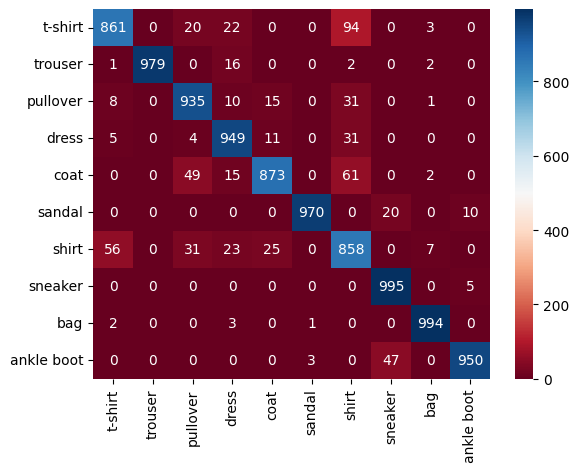

In [ ]:
cmatrix = confusion_matrix(y_true, y_test_pred_mn3)
sns.heatmap(cmatrix, annot=True, fmt=".0f", cmap='RdBu', xticklabels=labels_title, yticklabels=labels_title)
plt.show()

---
# Comparação
Com todos os dados registrados, podemos comparar visualmente os modelos abordados. Nessa seção, levaremos em consideração as métricas de acurácia, tempo de execução e máximo uso de memória, todos coletados durante a execução acima.

> Também, resgataremos os relatórios de classificação para tentarmos ver quais classes dão mais problema para serem determinadas.

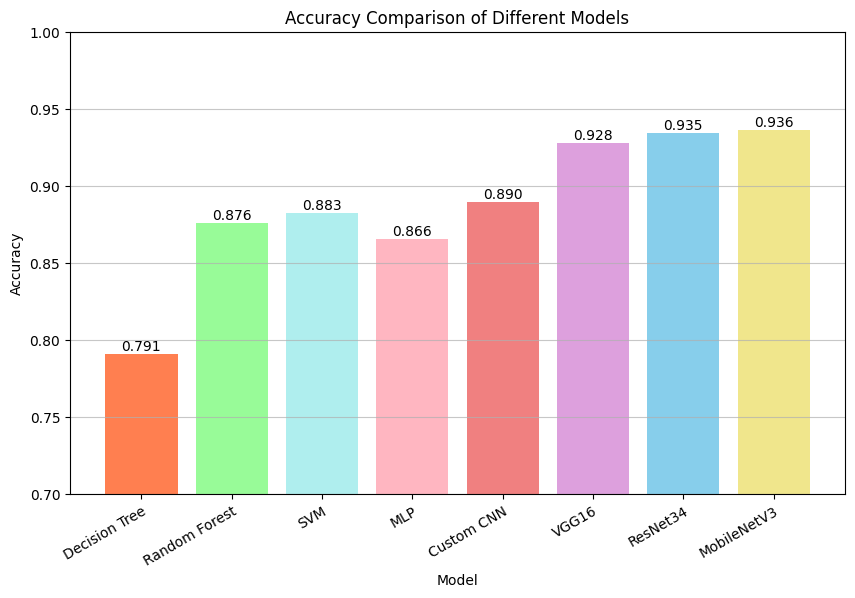

In [ ]:
model_names = list(models.keys())
accuracies = [model['Accuracy'] for model in models.values()]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
colors = [ 'coral', 'palegreen', 'paleturquoise', 'lightpink', 'lightcoral', 'plum', 'skyblue', 'khaki']

plt.figure(figsize=(10, 6))

acc_bars = plt.bar(model_names, accuracies, color=colors)
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.ylim(0.7, 1.0)

for bar, acc in zip(acc_bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0, f'{acc:.3f}', ha='center', va='bottom')

plt.show()

Pelo gráfico acima, é perceptível que as redes consolidadas (e pré treinadas) tiveram performance notavelmente superior, seguidas pela nossa rede convolucional própria. Isso evidencia a superioridade das convoluções na análise de imagens, assim como o impacto de um dataset diverso e volumoso (como no caso das redes consolidadas, treinadas no ImageNet).

> As relações de localidade e invariância presentes em imagens possibilitam as CNN de terem maior performance com menos custo.

> Os pesos pré treinados das CNNs consolidadas já aprenderam a extrair relações mais básicas e fundamentais, que podem ser reaproveitadas na nova aplicação. Bastando fazer o Fine Tuning.

Os melhores resultados foram da MobileNetV3 (seguido pela ResNet34 e VGG16), com valores acima de 90%.

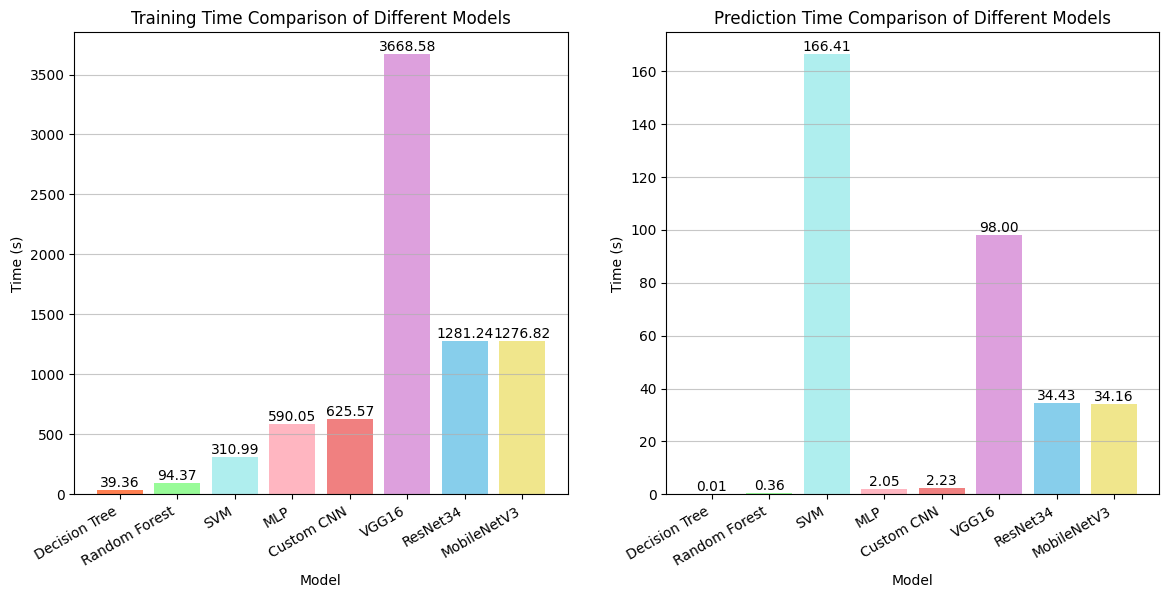

In [ ]:
model_names = list(models.keys())
trtimes = [model['Tr Time'] for model in models.values()]
prtimes = [model['Pr Time'] for model in models.values()]
colors = plt.cm.viridis(np.linspace(2, 3, len(model_names)))
colors = [ 'coral', 'palegreen', 'paleturquoise', 'lightpink', 'lightcoral', 'plum', 'skyblue', 'khaki']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

trtime_bars = ax1.bar(model_names, trtimes, color=colors)
ax1.set_title('Training Time Comparison of Different Models')
ax1.set_xlabel('Model')
ax1.set_ylabel('Time (s)')

ax1.set_xticks(np.arange(len(model_names)))
ax1.set_xticklabels(model_names, rotation=30, ha='right')
ax1.grid(axis='y', linestyle='-', alpha=0.7)

for bar, time in zip(trtime_bars, trtimes):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{time:.2f}', ha='center', va='bottom')

prtime_bars = ax2.bar(model_names, prtimes, color=colors)
ax2.set_title('Prediction Time Comparison of Different Models')
ax2.set_xlabel('Model')
ax2.set_ylabel('Time (s)')

ax2.set_xticks(np.arange(len(model_names)))
ax2.set_xticklabels(model_names, rotation=30, ha='right')
ax2.grid(axis='y', linestyle='-', alpha=0.7)

for bar, time in zip(prtime_bars, prtimes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f'{time:.2f}', ha='center', va='bottom')

plt.show()

Acima estão presentes o tempo de execução (treinaento e predição) de cada modelo. Percebe-se que as redes consolidadas tiveram tempo de treinamento maior que as demais, provavelmente devido a sua maior robustez e profundidade, lidando com imagens maiores e passando por mais convoluções.

> Note a discrepância da VGG16, que demorou cerca de uma hora. Isso deve ter ocorrido porquê, além das camadas convolucionais, a rede tem uma etapa de MLP convencional, que necessita de mais parâmetros e cálculos (sem poder aproveitar os recursos da GPU).

> Redes idealizadas após a elaboração da Network in Network (NiN), como a ResNet e a MobileNet, tendem a não possuir camadas totalmente conectadas (MLP), acelerando sua execução e poupando custos.

Os modelos base tiveram tempos diversas vezes melhor, especialmente a Decision Tree, que operou em menos de um minuto.

Quando se trata do tempo de predição, o cenário é batente semelhante, com diferença da SVM, que apresentou um tempo varias vezes maior que os demais modelos.

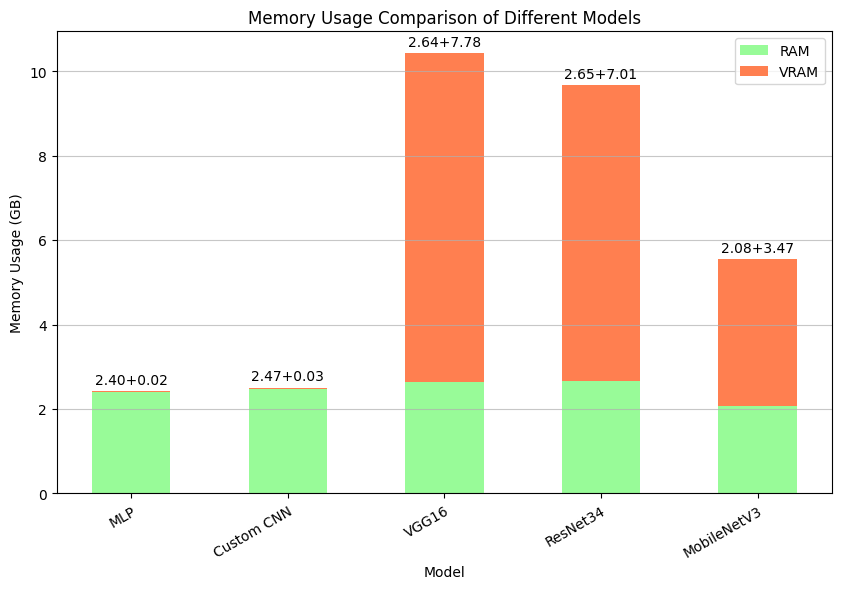

In [ ]:
vram_models = {name: specs for name, specs in models.items() if specs['RAM'] > 0}
model_names = list(vram_models)
ram_values = [model['RAM'] for model in vram_models.values()]
vram_values = [model['VRAM'] for model in vram_models.values()]
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

bar_width = 0.50
bar_positions = np.arange(len(model_names))

plt.figure(figsize=(10, 6))

plt.bar(bar_positions, ram_values, bar_width, label='RAM', color='palegreen')
plt.bar(bar_positions, vram_values, bar_width, bottom=ram_values, label='VRAM', color='coral')
plt.xlabel('Model')
plt.ylabel('Memory Usage (GB)')
plt.title('Memory Usage Comparison of Different Models')
plt.xticks(bar_positions, model_names, rotation=30, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.legend()

for idx, (ram_val, vram_val) in enumerate(zip(ram_values, vram_values)):
    total_val = ram_val + vram_val
    plt.text(idx, total_val + 0.1, f'{ram_val:.2f}+{vram_val:.2f}', ha='center', va='bottom')

plt.show()

Finalmente, temos o gráfico do uso de memória (RAM e VRAM). Percebe-se que o uso de RAM do sistema foi bem próximo em todas as aplicações (note que essa RAM é para o sistema todo, não apenas os modelos).

Já o uso de VRAM variou bastante. Enquanto a MLP (que não usa VRAM) e a CNN customizada usaram bem pouco, as redes consolidadas tiveram gastos potencialmente maiores. Um destaque ficou para a MobileNetV3, que gastou menos da metade que suas companheiras.

> A MobileNetV3 é pensada para rodar em dispositivos móveis, logo sua implementação foca em gastar menos recursos.

> Por usarmos funções próprias no `sklearn` para os modelos base, não foi possível registrar o uso de memória, mas foi visto que também ficou próximo dos 2 GB de RAM.

> Ao contrário do que geralmente se espera, a CNN customizada quase não usou VRAM. Porém, isso pode ser explicado pelo fato de usarmos as imagens pequenas originais (1 x 28 x 28), que não impactam muito na VRAM em apenas duas camadas convolucionais.

### Performance por Classe
Voltando aos relatórios de classificação emitidos pelo `classification_report` e `confusion_matrix`, vemos que a classe com pior desempenho em todos os modelos foi a número 6 (shirt). Isso pode ser justificado pela similaridade dessa classe com outras (como pullover, coat e t-shirt).

Todos os modelos tiveram melhor performance nas classes 1 (trouser) e 8 (trouser), seguidas por 5 (sandal) e 9 (ankle boot). É perceptível como essas classes tem características mais próprias e definidas, ajudando a diferencia-las das demais.

> O desempenho por classe foi analisado de acordo com o precision, recall e f1-score.

### Veredito
Pelos dados apontados acima, decidimos que a rede mais vantajosa foi a MobileNetV3, tendo maior acurácia que as demais, enquanto roda em um tempo razoável e usa menos RAM que as demais redes consolidadas. Caso se deseje um tempo ainda menor de execução e menos uso de memória, enquanto ainda mantém uma boa acurácia, a CNN customizada pode ser uma boa opção.

> Temos uma menção honrosa para a Random Forest, que teve uma acurácia basicamente igual à CNN enquanto rodou em um tempo mais que sete vezes menor.

## Considerações Finais
As redes MLP e CNN customizada foram treinadas por 15 épocas e as redes CNN Consolidadas foram treinadas por 5 épocas. O método de treinamento implementado possui um recurso de earlystopping e esperar todas as redes atingirem a parada (sem fixar uma quantidade de épocas) poderia ser uma forma de comparar os resultados finais e, possivelmente, aumentar ligeiramente o desempenho dos modelos. Contudo, preferimos fixar os números de épocas para comparar os modelos por quantidades iguais de treinamento.

A arquitetura dos modelos MLP e CNN foram escolhidas para tentar usar a maioria dos recursos disponíveis (como batch normalization e dropout), e alguns testes de variações foram feitos anteriormente. As redes de melhor resultado foram mantidas. Poderíamos, por exemplo, ter aumentado a parcela convolucional da CNN, porem, em todos os testes, a performance for pior.